In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np
import pandas as pd
import timeit
import re
import copy as cp

from preprocessing.data_norm import *
from preprocessing.make_idx import *
from preprocessing.make_team import *
from preprocessing.train import *

In [2]:
USE_GPU = True

dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device = torch.device('cpu')
print_every = 100
print('using device:', device)

using device: cpu


In [3]:
teamName = ["Atlanta Hawks", "Boston Celtics", "Brooklyn Nets", "Charlotte Bobcats", "Charlotte Hornets",
            "Chicago Bulls", "Cleveland Cavaliers", "Dallas Mavericks", "Denver Nuggets", "Detroit Pistons",
            "Golden State Warriors", "Houston Rockets", "Indiana Pacers", "Los Angeles Clippers", "Los Angeles Lakers",
            "Memphis Grizzlies", "Miami Heat", "Milwaukee Bucks", "Minnesota Timberwolves", "New Jeresy Nets",
            "New Orleans Hornets", "New Orleans Pelicans", "New York Knicks", "Oklahoma City Thunder", "Orlando Magic",
            "Philadelphia 76ers", "Phoenix Suns", "Portland Trail Blazers", "Sacramento Kings", "San Antonio Spurs",
            "Seattle SuperSonics", "Toronto Raptors", "Utah Jazz", "Vancouver Grizzlies", "Washington Bullets",
            "Washington Wizards"]

Abbr = ["ATL", "BOS", "BKN", "CHA", "CHO", "CHI", "CLE", "DAL", "DEN", "DET", "GSW", "HOU", "IND", "LAC", "LAL", "MEM",
        "MIA", "MIL", "MIN", "NJN", "NOH", "NOP", "NYK", "OKC", "ORL", "PHI", "PHO", "POR", "SAC", "SAS", "SEA", "TOR",
        "UTA", "VAN", "WSB", "WAS"]

In [4]:
# Index of used advanced metrics
need_idx = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 17, 18, 19, 20]
#need_idx = [ 1,20]

In [5]:
# 25 years training, 4 validation, 1 testing
trainYear = 25
startYear_train = 1989
validationYear = 4
startYear_validation = startYear_train + trainYear
testYear = 1
startYear_test = startYear_validation + validationYear

# Initialization for training set
player_list_train = [0] * trainYear
winrate_list_train = [0] * trainYear
data_list_train = [0] * trainYear
team_idx_train = [0] * trainYear
data_input_train = [0] * trainYear
loader_train = {}
loader_validation = {}
loader_test = {}

# Creating training data
for index in range(trainYear):
    # Read stats
    playerstats_train = "Player_Data/AvgPlayerStats" + str(index + startYear_train) + ".csv"
    teamstats_train = "Team_data/TeamStats" + str(index + startYear_train) + ".csv"
    # Convert type
    player_list_train[index] = pd.read_csv(playerstats_train).values
    winrate_list_train[index] = pd.read_csv(teamstats_train).values
    # Discard useless columns
    data_list_train[index] = player_list_train[index][:, 4:]
    # Normalization
    data_list_train[index] = data_norm(data_list_train[index])
    # Make abbreviations
    team_idx_train[index] = make_idx(winrate_list_train[index], Abbr, teamName)
    # Put players in same team together
    data_input_train[index] = make_team(player_list_train[index], data_list_train[index], team_idx_train[index],
                                        str(index + startYear_train), device, dtype, need_idx)
    # Put data into dictionary
    loader_train = dict(loader_train, **data_input_train[index])

# Initialization for validation set
player_list_validation = [0] * validationYear
winrate_list_validation = [0] * validationYear
data_list_validation = [0] * validationYear
team_idx_validation = [0] * validationYear
data_input_validation = [0] * validationYear

# Creating validation data
for index in range(validationYear):
    playerstats_validation = "Player_Data/AvgPlayerStats" + str(index + startYear_validation) + ".csv"
    teamstats_validation = "Team_Data/TeamStats" + str(index + startYear_validation) + ".csv"
    player_list_validation[index] = pd.read_csv(playerstats_validation).values
    winrate_list_validation[index] = pd.read_csv(teamstats_validation).values
    data_list_validation[index] = player_list_validation[index][:, 4:]
    data_list_validation[index] = data_norm(data_list_validation[index])
    team_idx_validation[index] = make_idx(winrate_list_validation[index], Abbr, teamName)
    data_input_validation[index] = make_team(player_list_validation[index], data_list_validation[index],
                                             team_idx_validation[index], str(index + startYear_validation), device,
                                             dtype, need_idx)
    loader_validation = dict(loader_validation, **data_input_validation[index])

# Initialization for testing data
player_list_test = [0] * testYear
winrate_list_test = [0] * testYear
data_list_test = [0] * testYear
team_idx_test = [0] * testYear
data_input_test = [0] * testYear

# Creating testing data
for index in range(testYear):
    playerstats_test = "Player_Data/AvgPlayerStats" + str(index + startYear_test) + ".csv"
    teamstats_test = "Team_Data/TeamStats" + str(index + startYear_test) + ".csv"
    player_list_test[index] = (pd.read_csv(playerstats_test)).values
    winrate_list_test[index] = (pd.read_csv(teamstats_test)).values
    data_list_test[index] = player_list_test[index][:, 4:]
    data_list_test[index] = data_norm(data_list_test[index])
    team_idx_test[index] = make_idx(winrate_list_test[index], Abbr, teamName)
    data_input_test[index] = make_team(player_list_test[index], data_list_test[index], team_idx_test[index],
                                       str(index + startYear_test), device, dtype, need_idx)


In [26]:
# Neural network setup
model = None
optimizer = None
num_data = 32

# A 4-layer network
# Each layer affine-norm-relu 
layer1 = nn.Sequential(
    nn.Linear(num_data, 1, bias=False),
    #nn.BatchNorm1d(1),
    #nn.LeakyReLU()
)

layer2 = nn.Sequential(
    nn.Linear(64, 1),
    #nn.BatchNorm1d(60),
    #nn.ReLU()
)

layer3 = nn.Sequential(
    nn.Linear(60, 30),
    nn.BatchNorm1d(30),
    nn.ReLU()
)

layer4 = nn.Sequential(
    nn.Linear(30, 1),
    #nn.BatchNorm1d(1),
    #nn.ReLU()
)

model = nn.Sequential(
    layer1,
    #layer2,
    #layer3,
    #layer4
)
# Learning rate can be changed - advised to be less than 2e-3
learning_rate = 13e-4
# Optimizer can be changed, but SGD works well. Weight_decay means to add an L2 regularization
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-4)

his_epoch, his_tra, his_val = train(model, loader_train, loader_validation, device, optimizer, dtype, epochs=1000,
                                    print_process=False,early_stop = True)


validation_loss:


E:\ece143\preprocessing\train.py:95: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  his_tra.append(loss_perepoch[0].data/25)


tensor(2.2634, grad_fn=<SelectBackward>)
0 tensor(1.3627, grad_fn=<DivBackward0>)
1 tensor(0.7267, grad_fn=<DivBackward0>)
2 tensor(0.5321, grad_fn=<DivBackward0>)
3 tensor(0.4359, grad_fn=<DivBackward0>)
4 tensor(0.3770, grad_fn=<DivBackward0>)
5 tensor(0.3371, grad_fn=<DivBackward0>)
6 tensor(0.3083, grad_fn=<DivBackward0>)
7 tensor(0.2867, grad_fn=<DivBackward0>)
8 tensor(0.2702, grad_fn=<DivBackward0>)
9 tensor(0.2572, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.3422, grad_fn=<SelectBackward>)
10 tensor(0.2469, grad_fn=<DivBackward0>)
11 tensor(0.2385, grad_fn=<DivBackward0>)
12 tensor(0.2315, grad_fn=<DivBackward0>)
13 tensor(0.2258, grad_fn=<DivBackward0>)
14 tensor(0.2209, grad_fn=<DivBackward0>)
15 tensor(0.2167, grad_fn=<DivBackward0>)
16 tensor(0.2130, grad_fn=<DivBackward0>)
17 tensor(0.2099, grad_fn=<DivBackward0>)
18 tensor(0.2071, grad_fn=<DivBackward0>)
19 tensor(0.2046, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.2360, grad_fn=<SelectBackward>)
20 tensor(0.2

tensor(0.1510, grad_fn=<SelectBackward>)
170 tensor(0.1638, grad_fn=<DivBackward0>)
171 tensor(0.1637, grad_fn=<DivBackward0>)
172 tensor(0.1637, grad_fn=<DivBackward0>)
173 tensor(0.1636, grad_fn=<DivBackward0>)
174 tensor(0.1636, grad_fn=<DivBackward0>)
175 tensor(0.1636, grad_fn=<DivBackward0>)
176 tensor(0.1635, grad_fn=<DivBackward0>)
177 tensor(0.1635, grad_fn=<DivBackward0>)
178 tensor(0.1635, grad_fn=<DivBackward0>)
179 tensor(0.1634, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1497, grad_fn=<SelectBackward>)
180 tensor(0.1634, grad_fn=<DivBackward0>)
181 tensor(0.1634, grad_fn=<DivBackward0>)
182 tensor(0.1633, grad_fn=<DivBackward0>)
183 tensor(0.1633, grad_fn=<DivBackward0>)
184 tensor(0.1633, grad_fn=<DivBackward0>)
185 tensor(0.1632, grad_fn=<DivBackward0>)
186 tensor(0.1632, grad_fn=<DivBackward0>)
187 tensor(0.1632, grad_fn=<DivBackward0>)
188 tensor(0.1631, grad_fn=<DivBackward0>)
189 tensor(0.1631, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1486, grad_fn=<

338 tensor(0.1606, grad_fn=<DivBackward0>)
339 tensor(0.1606, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1400, grad_fn=<SelectBackward>)
340 tensor(0.1606, grad_fn=<DivBackward0>)
341 tensor(0.1606, grad_fn=<DivBackward0>)
342 tensor(0.1606, grad_fn=<DivBackward0>)
343 tensor(0.1606, grad_fn=<DivBackward0>)
344 tensor(0.1606, grad_fn=<DivBackward0>)
345 tensor(0.1606, grad_fn=<DivBackward0>)
346 tensor(0.1606, grad_fn=<DivBackward0>)
347 tensor(0.1606, grad_fn=<DivBackward0>)
348 tensor(0.1605, grad_fn=<DivBackward0>)
349 tensor(0.1605, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1398, grad_fn=<SelectBackward>)
350 tensor(0.1605, grad_fn=<DivBackward0>)
351 tensor(0.1605, grad_fn=<DivBackward0>)
352 tensor(0.1605, grad_fn=<DivBackward0>)
353 tensor(0.1605, grad_fn=<DivBackward0>)
354 tensor(0.1605, grad_fn=<DivBackward0>)
355 tensor(0.1605, grad_fn=<DivBackward0>)
356 tensor(0.1605, grad_fn=<DivBackward0>)
357 tensor(0.1605, grad_fn=<DivBackward0>)
358 tensor(0.1605, grad_

505 tensor(0.1596, grad_fn=<DivBackward0>)
506 tensor(0.1596, grad_fn=<DivBackward0>)
507 tensor(0.1596, grad_fn=<DivBackward0>)
508 tensor(0.1596, grad_fn=<DivBackward0>)
509 tensor(0.1596, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1371, grad_fn=<SelectBackward>)
510 tensor(0.1596, grad_fn=<DivBackward0>)
511 tensor(0.1596, grad_fn=<DivBackward0>)
512 tensor(0.1596, grad_fn=<DivBackward0>)
513 tensor(0.1596, grad_fn=<DivBackward0>)
514 tensor(0.1596, grad_fn=<DivBackward0>)
515 tensor(0.1596, grad_fn=<DivBackward0>)
516 tensor(0.1596, grad_fn=<DivBackward0>)
517 tensor(0.1596, grad_fn=<DivBackward0>)
518 tensor(0.1596, grad_fn=<DivBackward0>)
519 tensor(0.1596, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1370, grad_fn=<SelectBackward>)
520 tensor(0.1596, grad_fn=<DivBackward0>)
521 tensor(0.1596, grad_fn=<DivBackward0>)
522 tensor(0.1596, grad_fn=<DivBackward0>)
523 tensor(0.1596, grad_fn=<DivBackward0>)
524 tensor(0.1596, grad_fn=<DivBackward0>)
525 tensor(0.1596, grad_

672 tensor(0.1591, grad_fn=<DivBackward0>)
673 tensor(0.1591, grad_fn=<DivBackward0>)
674 tensor(0.1591, grad_fn=<DivBackward0>)
675 tensor(0.1591, grad_fn=<DivBackward0>)
676 tensor(0.1591, grad_fn=<DivBackward0>)
677 tensor(0.1591, grad_fn=<DivBackward0>)
678 tensor(0.1591, grad_fn=<DivBackward0>)
679 tensor(0.1591, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1363, grad_fn=<SelectBackward>)
680 tensor(0.1591, grad_fn=<DivBackward0>)
681 tensor(0.1591, grad_fn=<DivBackward0>)
682 tensor(0.1591, grad_fn=<DivBackward0>)
683 tensor(0.1591, grad_fn=<DivBackward0>)
684 tensor(0.1591, grad_fn=<DivBackward0>)
685 tensor(0.1591, grad_fn=<DivBackward0>)
686 tensor(0.1591, grad_fn=<DivBackward0>)
687 tensor(0.1591, grad_fn=<DivBackward0>)
688 tensor(0.1591, grad_fn=<DivBackward0>)
689 tensor(0.1591, grad_fn=<DivBackward0>)
validation_loss:
tensor(0.1363, grad_fn=<SelectBackward>)
690 tensor(0.1590, grad_fn=<DivBackward0>)
691 tensor(0.1590, grad_fn=<DivBackward0>)
692 tensor(0.1590, grad_

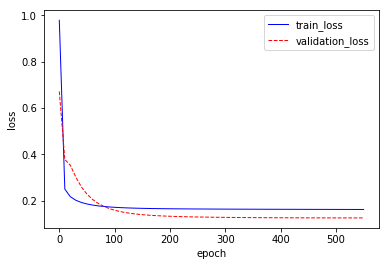

In [14]:
from matplotlib import pyplot as plt

# Plotting losses
l1 = plt.plot(his_epoch, his_tra, color='blue', linewidth=1.0, label='line')
l2 = plt.plot(his_epoch, his_val, color='red', linewidth=1.0, linestyle='--', label='line')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(labels=['train_loss', 'validation_loss'], loc='best')
plt.show()


In [ ]:
# Warning, next cell saves a new model
stop

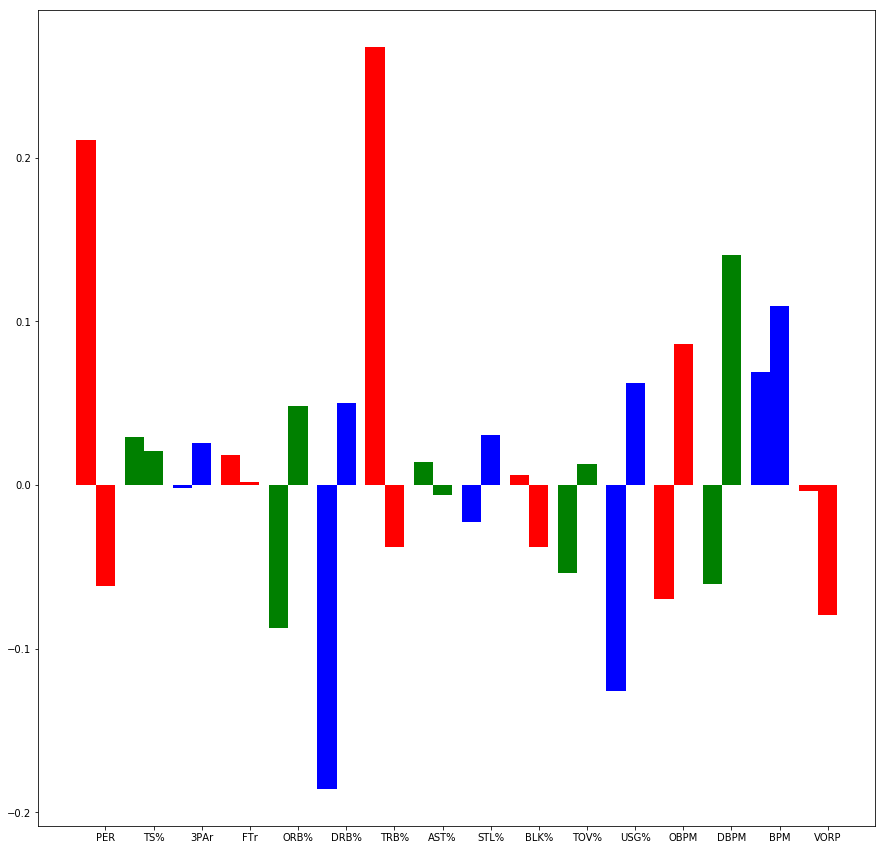

In [23]:
# Visualization of the weights
data_name = ['PER', 'TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OBPM',
             'DBPM', 'BPM', 'VORP']
weight = model.state_dict()['0.0.weight'][0]
bar_width = 0.4
x_axis = np.arange(len(data_name))
y_axis_1 = tuple(weight[:16])
y_axis_2 = tuple(weight[16:32])
poly1 = plt.bar(x_axis, y_axis_1, bar_width, color='rgb')
poly2 = plt.bar(x_axis + 0.4, y_axis_2, bar_width, color='rgb')
plt.xticks(x_axis + 0.4, data_name)
plt.gcf().set_size_inches(15, 15)

In [ ]:
plt.savefig('trained_model\index_code1_poly2.2.png')

E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


tensor(0.0996, grad_fn=<ThAddBackward>)
tensor(0.1740, grad_fn=<ThAddBackward>)
tensor(0.1427, grad_fn=<ThAddBackward>)
tensor(0.0897, grad_fn=<ThAddBackward>)


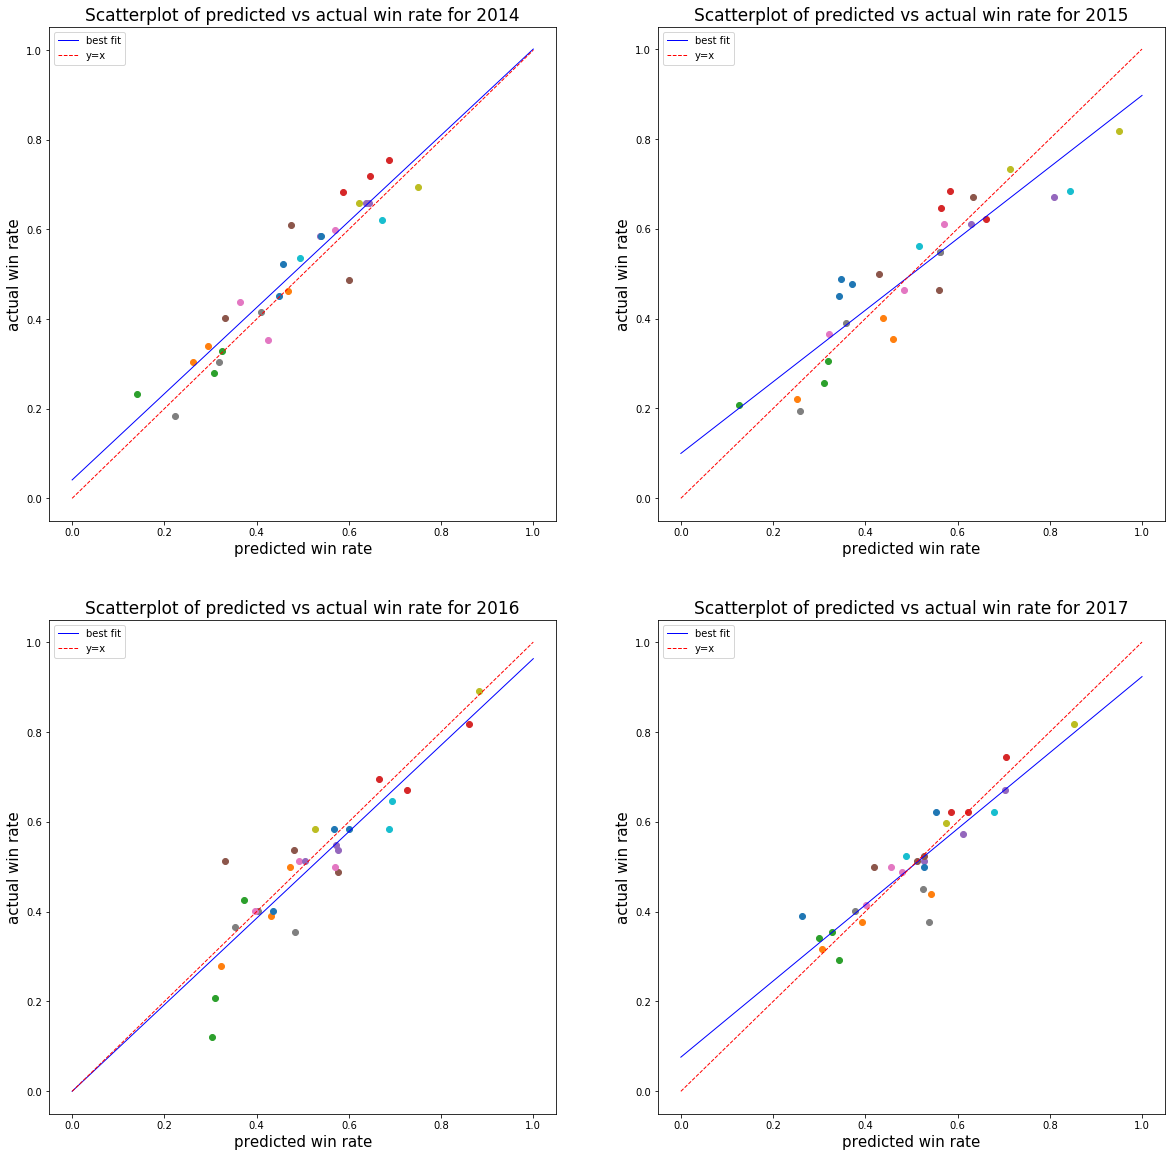

In [24]:
# Display validation set results

for i in range(4):
    x = []
    y = []
    loss = 0
    plt.subplot(2, 2, i + 1)
    for t, content in data_input_validation[i].items():
        PER_C = model(content[0])
        # Loss is the mean square error
        win_rate = sum(PER_C)
        plt.scatter(win_rate[0].data, content[1][0].data)
        x.append(win_rate[0].data)
        y.append(content[1][0].data)
        loss += (win_rate[0] - content[1][0].data) ** 2
    print(loss)
    z1 = np.polyfit(x, y, 1)
    p1 = np.poly1d(z1)
    x = np.linspace(0, 1, 100)
    y = z1[0] * x + z1[1]

    l1 = plt.plot(x, y, color='blue', linewidth=1.0, label='line')
    x = np.linspace(0, 1, 100)
    y = x
    l2 = plt.plot(x, y, color='red', linewidth=1.0, linestyle='--', label='line')
    plt.gcf().set_size_inches(20, 20)
    plt.xlabel("predicted win rate",fontsize = 15)
    plt.ylabel("actual win rate",fontsize = 15)
    plt.title('Scatterplot of predicted vs actual win rate for '+str(i+2014),fontsize = 17)
    plt.legend(labels=['best fit', 'y=x'], loc='best')
    #plt.savefig('trained_model\index_code1_val_poly2.7_test.png')plt.savefig('trained_model\index_code1_val_poly2.8.png')
plt.show()


E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:15: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  from ipykernel import kernelapp as app


tensor(0.1411, grad_fn=<ThAddBackward>)


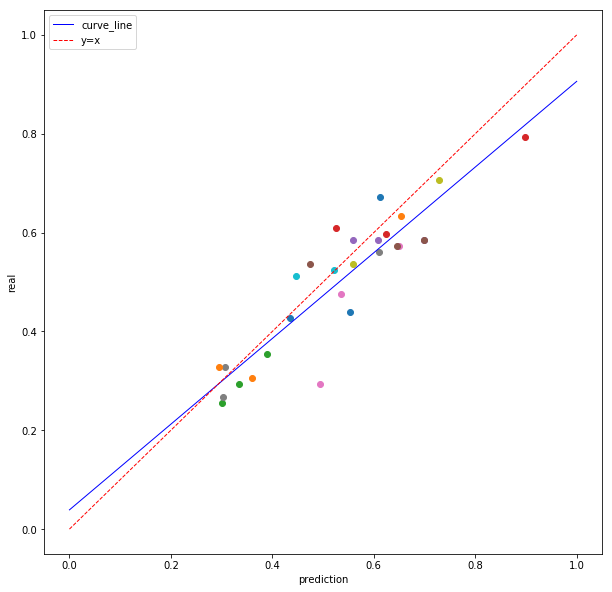

In [25]:
# Display testing set results

x = []
y = []
loss = 0
pre_dic = {}

for t, content in data_input_test[0].items():
    PER_C = model(content[0])
    # Loss is the mean square error
    win_rate = sum(PER_C)
    plt.scatter(win_rate[0].data, content[1][0].data)
    x.append(win_rate[0].data)
    y.append(content[1][0].data)
    loss += (win_rate[0] - content[1][0].data) ** 2
    pre_dic[t] = win_rate[0].data
print(loss)
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)
x = np.linspace(0, 1, 100)
y = z1[0] * x + z1[1]

l1 = plt.plot(x, y, color='blue', linewidth=1.0, label='line')
x = np.linspace(0, 1, 100)
y = x
l2 = plt.plot(x, y, color='red', linewidth=1.0, linestyle='--', label='line')
plt.gcf().set_size_inches(10, 10)
plt.ylabel("real")
plt.xlabel("prediction")
plt.legend(labels=['curve_line', 'y=x'], loc='best')
#plt.savefig('trained_model\index_code1_val_poly2.7_test.png')
plt.show()


In [ ]:
plt.savefig('trained_model\index_code1_val_poly2.7_test.png')

In [ ]:
# Warning - This cell will overwrite the previous model
torch.save(model, 'trained_model\index_code1_poly2.5.fit')
torch.save(model.state_dict(), 'trained_model\index_code1_poly2.5.pkl')

model.state_dict()


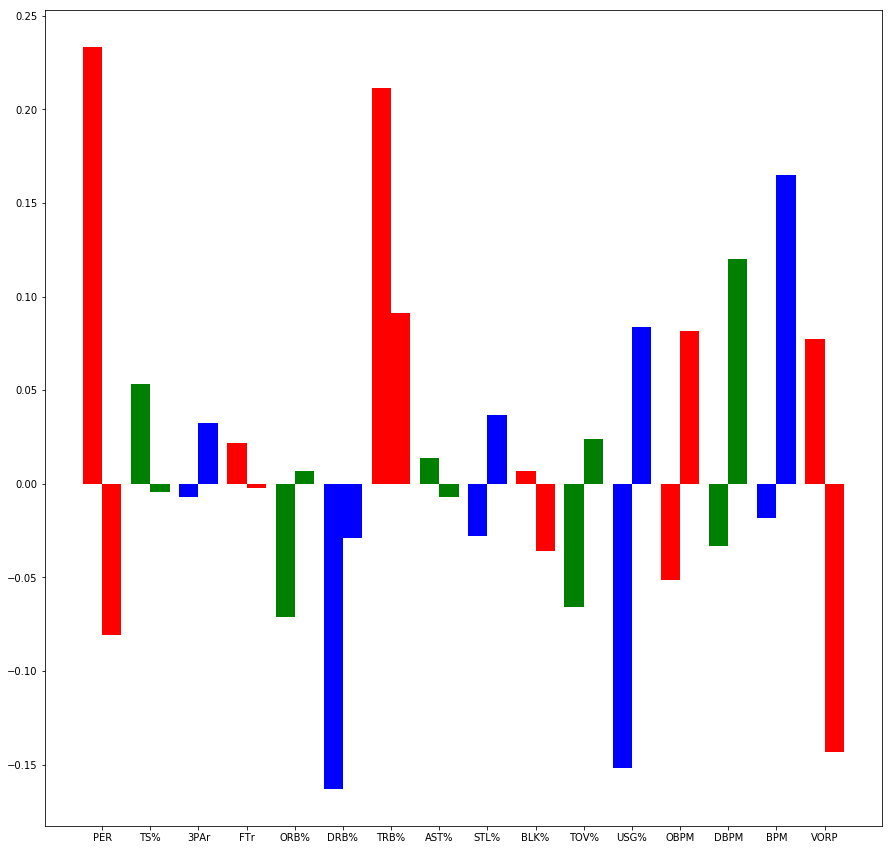

In [18]:
# Load the existing model and compare it with a newly-trained one
model_compare = torch.load('trained_model/index_code1_poly2.2.fit')
model_compare.state_dict()
weight = model_compare.state_dict()['0.0.weight'][0]
bar_width = 0.4
x_axis = np.arange(len(data_name))
y_axis_1 = tuple(weight[:16])
y_axis_2 = tuple(weight[16:32])
poly1 = plt.bar(x_axis, y_axis_1, bar_width, color='rgb')
poly2 = plt.bar(x_axis + 0.4, y_axis_2, bar_width, color='rgb')
plt.xticks(x_axis + 0.2, data_name)
plt.gcf().set_size_inches(15, 15)
plt.savefig('trained_model\index_code1_poly2.2.png')


In [ ]:
import matplotlib.image as mpimg#mpimg
show_his = [None]*6
for i in range(6):
    show_his[i] = mpimg.imread('trained_model\index_code1_polycompare'+str(i+1)+'.png')
    plt.subplot(2, 3, i+1)
    plt.gcf().set_size_inches(15, 10)
    plt.imshow(show_his[i])

E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:11: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # This is added back by InteractiveShellApp.init_path()
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:14: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  


tensor(0.1334, grad_fn=<ThAddBackward>)
tensor(0.1762, grad_fn=<ThAddBackward>)
tensor(0.1693, grad_fn=<ThAddBackward>)
tensor(0.1255, grad_fn=<ThAddBackward>)


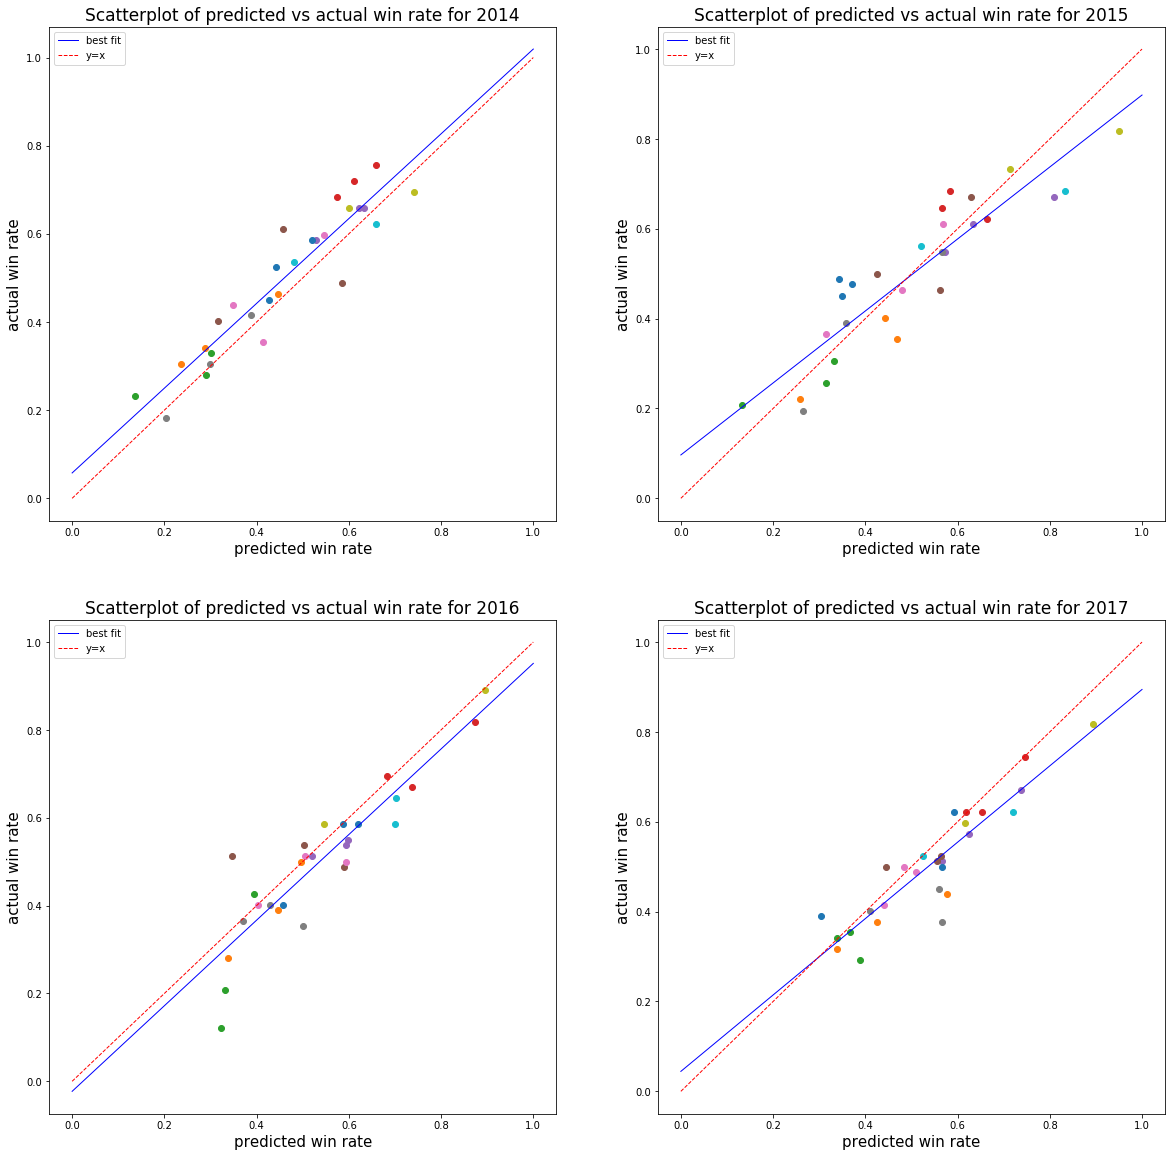

In [19]:
# Display validation set results
for i in range(4):
    x = []
    y = []
    loss = 0
    plt.subplot(2, 2, i + 1)
    for t, content in data_input_validation[i].items():
        PER_C = model_compare(content[0])
        # Loss is the mean square error
        win_rate = sum(PER_C)
        plt.scatter(win_rate[0].data, content[1][0].data)
        x.append(win_rate[0].data)
        y.append(content[1][0].data)
        loss += (win_rate[0] - content[1][0].data) ** 2
    print(loss)
    z1 = np.polyfit(x, y, 1)
    p1 = np.poly1d(z1)
    x = np.linspace(0, 1, 100)
    y = z1[0] * x + z1[1]

    l1 = plt.plot(x, y, color='blue', linewidth=1.0, label='line')
    x = np.linspace(0, 1, 100)
    y = x
    l2 = plt.plot(x, y, color='red', linewidth=1.0, linestyle='--', label='line')
    plt.gcf().set_size_inches(20, 20)

    plt.xlabel("predicted win rate",fontsize = 15)
    plt.ylabel("actual win rate",fontsize = 15)
    plt.title('Scatterplot of predicted vs actual win rate for '+str(i+2014),fontsize = 17)
    plt.legend(labels=['best fit', 'y=x'], loc='best')
    
plt.show()


E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:10: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  # Remove the CWD from sys.path while we load stuff.
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':
E:\Anaconda\envs\cs231n\lib\site-packages\ipykernel_launcher.py:13: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  del sys.path[0]


tensor(0.1138, grad_fn=<ThAddBackward>)


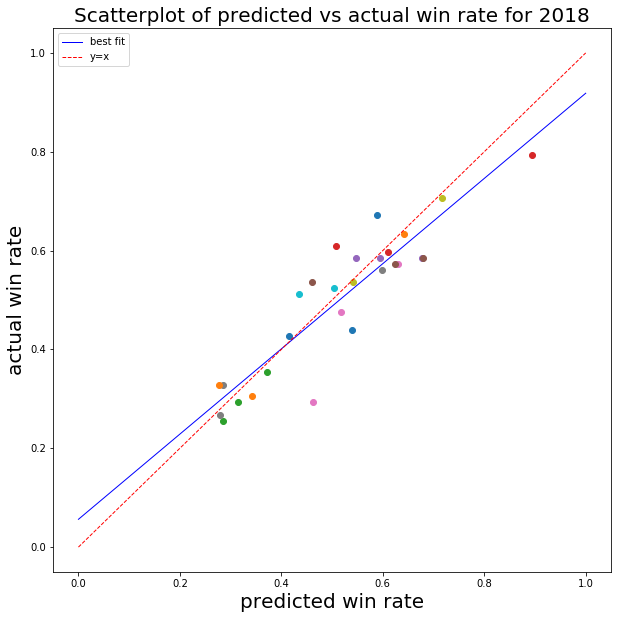

In [20]:
# Display testing set results
x = []
y = []
loss = 0
pre_dic_compare = {}
for t, content in data_input_test[0].items():
    PER_C = model_compare(content[0])
    # Loss is the mean square error
    win_rate = sum(PER_C)
    plt.scatter(win_rate[0].data, content[1][0].data,label = 'w')
    x.append(win_rate[0].data)
    y.append(content[1][0].data)
    loss += (win_rate[0] - content[1][0].data) ** 2
    pre_dic_compare[t] = win_rate[0].data
print(loss)
z1 = np.polyfit(x, y, 1)
p1 = np.poly1d(z1)
x = np.linspace(0, 1, 100)
y = z1[0] * x + z1[1]

# Displaying plots for data
l1 = plt.plot(x, y, color='blue', linewidth=1.0, label='line')
x = np.linspace(0, 1, 100)
y = x
l2 = plt.plot(x, y, color='red', linewidth=1.0, linestyle='--', label='line')
plt.gcf().set_size_inches(10, 10)
plt.ylabel("actual win rate",fontsize = 20)
plt.xlabel("predicted win rate",fontsize = 20)
plt.title('Scatterplot of predicted vs actual win rate for 2018',fontsize = 20)
plt.legend(labels=['best fit', 'y=x'], loc='best')

plt.show()


In [ ]:
print(pre_dic_compare)

In [ ]:
print(pre_dic)

In [ ]:
betting_data = [0] * testYear
prediction = []

for index in range(testYear):
    betting_file = "Betting_Data/bettingOdds" + str(startYear_test) + ".csv"
    betting_data[index] = (pd.read_csv(betting_file)).values
    prefix='Prediction_Result'
    version=startYear_test+index
    with open('Prediction_Result.txt', 'w') as part:
        for i in range(len(betting_data[index])):
            host_position = teamName.index((betting_data[index][i][0]))
            host_Abbr = Abbr[host_position] + str(startYear_test)
            visiting_position = teamName.index((betting_data[index][i][1]))
            visiting_Abbr =  Abbr[visiting_position] + str(startYear_test)
            if (host_Abbr in pre_dic and visiting_Abbr in pre_dic):
                host_winrate = np.array(pre_dic[host_Abbr],dtype = 'float32')
                
                visiting_winrate = np.array(pre_dic[visiting_Abbr],dtype = 'float32')
                
                host_odds = betting_data[index][i][2]
                visiting_odds = betting_data[index][i][3]
                host_winrate1 = (host_winrate) / (host_winrate + visiting_winrate)
                host_winrate1 = np.around(host_winrate1, decimals=4, out=None)
                visiting_winrate1 = (visiting_winrate) / (host_winrate + visiting_winrate)
                visiting_winrate1 = np.around(visiting_winrate1, decimals=4, out=None)
                if (host_odds > 0):
                    host_win = host_winrate * host_odds * (-visiting_odds * 100 + 100)
                    visiting_win = visiting_winrate * (-visiting_odds * 100 + 100)
                else:
                    host_win = host_winrate * (-host_odds * 100 + 100)
                    visiting_win = visiting_winrate * visiting_odds * (-host_odds * 100 + 100)
                if (host_win >= visiting_win):
                    result = Abbr[host_position]
                else:
                    result = Abbr[visiting_position]
                result = 'Match: ' + host_Abbr + ' vs ' + visiting_Abbr + ' | ' + 'Win Prob: ' + str(
                    host_winrate1) + ' vs ' + str(visiting_winrate1) + ' | ' + 'Odds: ' + str(host_odds) + ' to ' + str(
                    visiting_odds) + ' | ' + 'Recommendation: ' + result + '\n'
                part.write(result)
print(type(host_winrate))
